In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
batch = 64

transform = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5)),
        ])

data_mnist = datasets.MNIST('dataset', train=True, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(data_mnist, batch_size=batch, drop_last=True)

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d( 1, 16, kernel_size=4, stride=2, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(2048, 1)
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x

In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        hid = 64
        self.convT1 = nn.ConvTranspose2d(input_dim, hid * 8, kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(hid * 8)
        self.convT2 = nn.ConvTranspose2d(hid * 8, hid * 4, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(hid * 4)
        self.convT3 = nn.ConvTranspose2d(hid * 4, hid * 2, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(hid * 2)
        self.convT4 = nn.ConvTranspose2d(hid * 2, hid, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(hid)
        self.convT5 = nn.ConvTranspose2d(hid, 1, kernel_size=4, stride=2, padding=1)
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)        
    
    def forward(self, z):
        x = F.relu(self.bn1(self.convT1(z)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        x = torch.tanh(self.convT5(x))
        return x

In [5]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [6]:
netG = Generator(100)
netD = Discriminator(3)

netG.weight_init(mean=0.0, std=0.02)
netD.weight_init(mean=0.0, std=0.02)
netG.cuda()
netD.cuda()

# loss function
loss_fn = nn.BCELoss()
real_label = 1.
fake_label = 0.
real_labels = torch.full((64,), real_label, dtype=torch.float32).cuda()
fake_labels = torch.full((64,), fake_label, dtype=torch.float32).cuda()

# Optimizers
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.999

optimizerD = optim.Adam(netD.parameters(), lr = learning_rate, betas = (beta_1, beta_2))
optimizerG = optim.Adam(netG.parameters(), lr = learning_rate, betas = (beta_1, beta_2)) 

In [7]:
G_losses = []
D_losses = []
generated_images = []
num_epochs = 20
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        # Update discriminator
        netD.zero_grad()
        inputs, _ = data
        inputs = inputs.cuda()
        real_dis_preds = netD(inputs).view(-1)
        loss_real = loss_fn(real_dis_preds, real_labels)
        loss_real.backward()
        
        netG.zero_grad()
        random_noise = torch.randn(64, 100, 1, 1).cuda()
        fake_images = netG(random_noise)
        fake_dis_pred = netD(fake_images.detach()).view(-1)
        fake_loss = loss_fn(fake_dis_pred, fake_labels)
        fake_loss.backward()
        optimizerD.step()
        dis_error = loss_real + fake_loss
        
        # Update generator
        dis_out = netD(fake_images).view(-1)
        gen_loss = loss_fn(dis_out, real_labels)
        gen_loss.backward()
        optimizerG.step()
        
        G_losses.append(gen_loss.item())
        D_losses.append(loss_real.item())        
        
        if not i % 300:
            with torch.no_grad():
                image = netG(random_noise).permute(0, 2, 3, 1).cpu().detach().numpy()
                generated_images.append(image)
    print(f'Epoch {epoch:2d}:  D-Loss: {loss_real:.6f}, G-Loss: {gen_loss:.6f}')

Epoch  0:  D-Loss: 0.181264, G-Loss: 2.138983
Epoch  1:  D-Loss: 0.166080, G-Loss: 2.558889
Epoch  2:  D-Loss: 0.137126, G-Loss: 2.636892
Epoch  3:  D-Loss: 0.057859, G-Loss: 2.717479
Epoch  4:  D-Loss: 0.201317, G-Loss: 2.911217
Epoch  5:  D-Loss: 0.131549, G-Loss: 2.362492
Epoch  6:  D-Loss: 0.435826, G-Loss: 2.344015
Epoch  7:  D-Loss: 0.230618, G-Loss: 2.343359
Epoch  8:  D-Loss: 0.123791, G-Loss: 3.448752
Epoch  9:  D-Loss: 0.195046, G-Loss: 2.949810
Epoch 10:  D-Loss: 0.070265, G-Loss: 3.537741
Epoch 11:  D-Loss: 0.418534, G-Loss: 3.335212
Epoch 12:  D-Loss: 0.338027, G-Loss: 2.752501
Epoch 13:  D-Loss: 0.112434, G-Loss: 3.861819
Epoch 14:  D-Loss: 0.024229, G-Loss: 4.676836
Epoch 15:  D-Loss: 0.065427, G-Loss: 4.174171
Epoch 16:  D-Loss: 0.049312, G-Loss: 3.656585
Epoch 17:  D-Loss: 0.107894, G-Loss: 4.675851
Epoch 18:  D-Loss: 0.186895, G-Loss: 2.535212
Epoch 19:  D-Loss: 0.426095, G-Loss: 1.918891


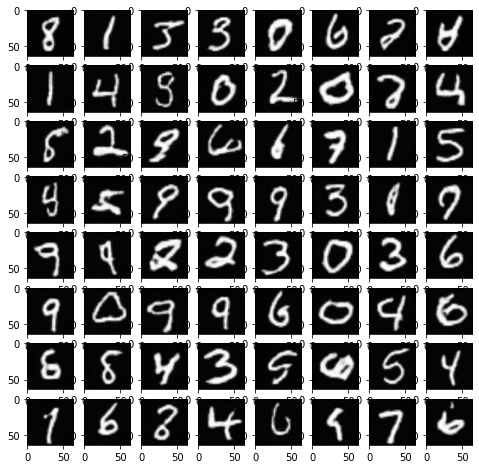

In [8]:
columns = 8
rows = 8
img_list = np.array(generated_images, dtype=np.float32)[-1]
fig = plt.figure(figsize=(8,8))
plt.axis("off")
for i in range(1, columns*rows+1):
    img = img_list[i-1].reshape((64, 64))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

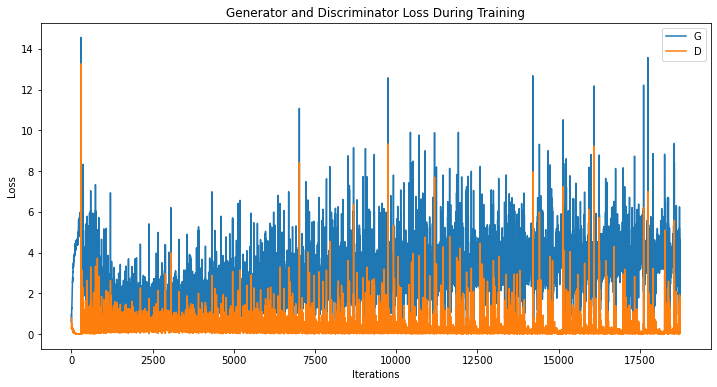

In [9]:
plt.figure(figsize=(12,6))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()